In [1]:
import urllib.request
import os.path
import numpy
import netCDF4
import scipy.sparse
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
def fetch_file_from_web(url, filename=None, force_download=False):
    """Download file from url and optionally names it as filename"""
    if filename is None: local_file = os.path.split(url)[-1]
    else: local_file = filename
    if not os.path.isfile(local_file) or force_download:
        print('Downloading file %s ...'%local_file)
        urllib.request.urlretrieve(url, local_file)
        print(' ...done.')

# Load ocean grid

In [3]:
fetch_file_from_web('ftp://ftp.gfdl.noaa.gov/home/aja/OM4_05_grid.unpacked/ocean_hgrid.nc')
fetch_file_from_web('ftp://ftp.gfdl.noaa.gov/home/aja/OM4_05_grid.unpacked/ocean_static.nc')

In [4]:
ocn_mask = netCDF4.Dataset('ocean_static.nc').variables['wet'][:] # 1=ocean, 0=land
ocn_area = netCDF4.Dataset('ocean_static.nc').variables['areacello'][:]
ocn_lon = netCDF4.Dataset('ocean_static.nc').variables['geolon'][:] # Cell-center longitudes
ocn_lat = netCDF4.Dataset('ocean_static.nc').variables['geolat'][:] # Cell-center latitudes
ocn_qlon = netCDF4.Dataset('ocean_hgrid.nc').variables['x'][::2,::2] # Mesh longitudes (cell corners)
ocn_qlat = netCDF4.Dataset('ocean_hgrid.nc').variables['y'][::2,::2] # Mesh latitudes (cell corners)
print('Implied planetary radius =',numpy.sqrt( ocn_area.sum()/(4*numpy.pi) )/1e3,'km')

# Reduce ocean resolution for testing
# set reduce_cycles = 0 to leave grid unchanged
reduce_cycles = 0
def reduce_by_2(ocn_mask, ocn_area, ocn_lon, ocn_lat, ocn_qlon, ocn_qlat, mask_cutoff=1):
    ocn_area = ocn_area[::2,::2] + ocn_area[1::2,::2] + ocn_area[::2,1::2] + ocn_area[1::2,1::2]
    ocn_mask = ocn_mask[::2,::2] + ocn_mask[1::2,::2] + ocn_mask[::2,1::2] + ocn_mask[1::2,1::2]
    ocn_mask[ocn_mask<mask_cutoff] = 0
    ocn_mask[ocn_mask>1] = 1
    ocn_lon = ocn_qlon[1::2,1::2]
    ocn_lat = ocn_qlat[1::2,1::2]
    ocn_qlon = ocn_qlon[::2,::2]
    ocn_qlat = ocn_qlat[::2,::2]
    return ocn_mask, ocn_area, ocn_lon, ocn_lat, ocn_qlon, ocn_qlat
print('Original ocean grid: %ix%i',ocn_mask.shape)
for cycle in range(reduce_cycles):
    ocn_mask, ocn_area, ocn_lon, ocn_lat, ocn_qlon, ocn_qlat = reduce_by_2(ocn_mask, ocn_area, ocn_lon, ocn_lat, ocn_qlon, ocn_qlat)
print('Reduced ocean grid: %ix%i',ocn_mask.shape)
ocn_nj, ocn_ni = ocn_mask.shape
if ocn_qlat.shape != (ocn_nj+1,ocn_ni+1): raise Exception('ocn_qlat has wrong shape')
if ocn_qlon.shape != (ocn_nj+1,ocn_ni+1): raise Exception('ocn_qlon has wrong shape')
if ocn_lat.shape != (ocn_nj,ocn_ni): raise Exception('ocn_lat has wrong shape')
if ocn_lon.shape != (ocn_nj,ocn_ni): raise Exception('ocn_lon has wrong shape')
if ocn_area.shape != (ocn_nj,ocn_ni): raise Exception('ocn_area has wrong shape')

Implied planetary radius = 6342.94394322 km
Original ocean grid: %ix%i (576, 720)
Reduced ocean grid: %ix%i (576, 720)


In [5]:
# Use for making plots regional
def regional_plot():
    #return # Comment to make regional plots
    xx, yy = (-250,-200), (-45,-5) # Australia
    #xx, yy = (-60,-30), (-10,10) # Amazon
    #xx, yy = (0,20), (-10,2) # Congo
    #xx, yy = (-100,-70), (15,32) # Gulf of Mexico
    #xx, yy = (50, 70), (60, 70) # Tri-polar singularity
    #xx, yy = (50, 70), (-5, 5) # Tri-polar singularity
    xx, yy = (-90,-10), (45,85) # Greenland
    if plt.xlim()[0]<0:
        plt.xlim(xx); plt.ylim(yy);
    else:
        plt.xlim(xx[0] % 360,xx[1] % 360); plt.ylim(yy);
#onan = numpy.ma.array(omsk, mask=(omsk==0)) # Uncomment to mask
onan = 1 # Uncomment to stopping masking

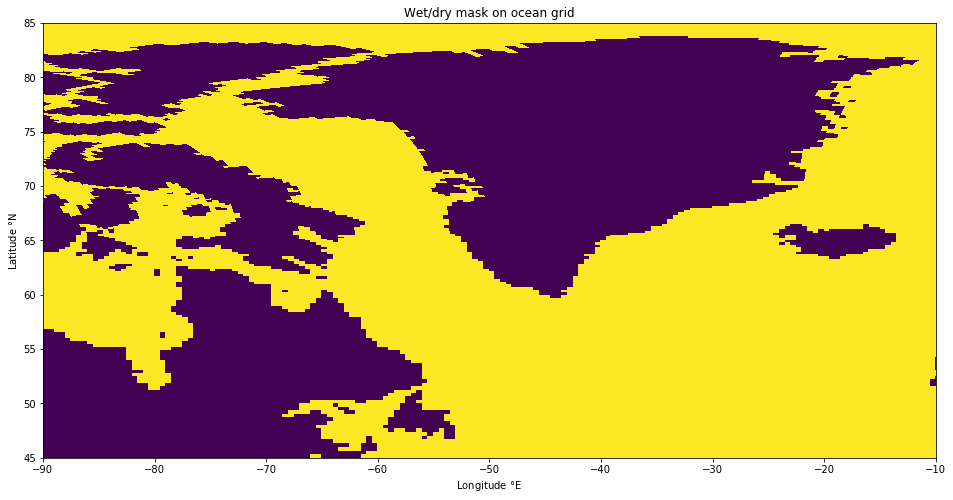

In [6]:
plt.figure(figsize=(16,8))
plt.pcolormesh(ocn_qlon,ocn_qlat,onan*ocn_mask);
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('Wet/dry mask on ocean grid');
regional_plot()

# Define a coastal mask

In [7]:
cst_mask = 0 * ocn_mask # All land should be 0
cst_mask[ (ocn_mask>0) & (numpy.roll(ocn_mask,1,axis=1)==0) ] = 1 # Land to the west
cst_mask[ (ocn_mask>0) & (numpy.roll(ocn_mask,-1,axis=1)==0) ] = 1 # Land to the east
cst_mask[ (ocn_mask>0) & (numpy.roll(ocn_mask,1,axis=0)==0) ] = 1 # Land to the south
#cst_mask[ (ocn_mask>0) & (numpy.roll(numpy.roll(ocn_mask,1,axis=0),1,axis=1)==0) ] = 1 # Land to the south-west
#cst_mask[ (ocn_mask>0) & (numpy.roll(numpy.roll(ocn_mask,1,axis=0),-1,axis=1)==0) ] = 1 # Land to the south-east
nom = numpy.roll(ocn_mask,-1,axis=0) # Shift southward
nom[-1,:] = ocn_mask[-1,::-1] # Tri-polar fold
cst_mask[ (ocn_mask>0) & (nom==0) ] = 1 # Land to the north
#cst_mask[ (ocn_mask>0) & (numpy.roll(nom,1,axis=1)==0) ] = 1 # Land to the north-west
#cst_mask[ (ocn_mask>0) & (numpy.roll(nom,-1,axis=1)==0) ] = 1 # Land to the north-east
del nom # Clean up

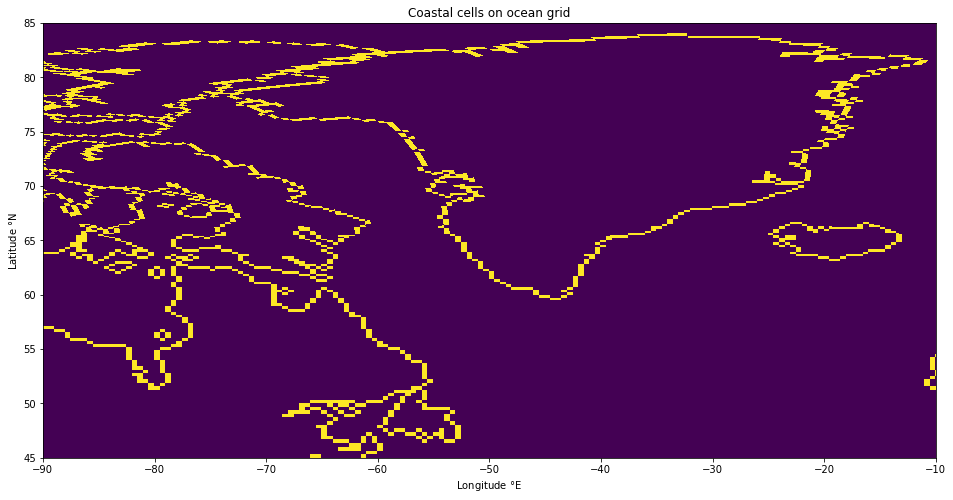

In [8]:
plt.figure(figsize=(16,8))
plt.pcolormesh(ocn_qlon, ocn_qlat, cst_mask);
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('Coastal cells on ocean grid');
regional_plot()

# Label ocean cells with nearest coastal cell

Ice 9 approach to propogate the coastal cell id (ocid) across ocean grid letting each cell know where it's nearest coastal wet-point neighbor, for all points in the grid (land and ocean).

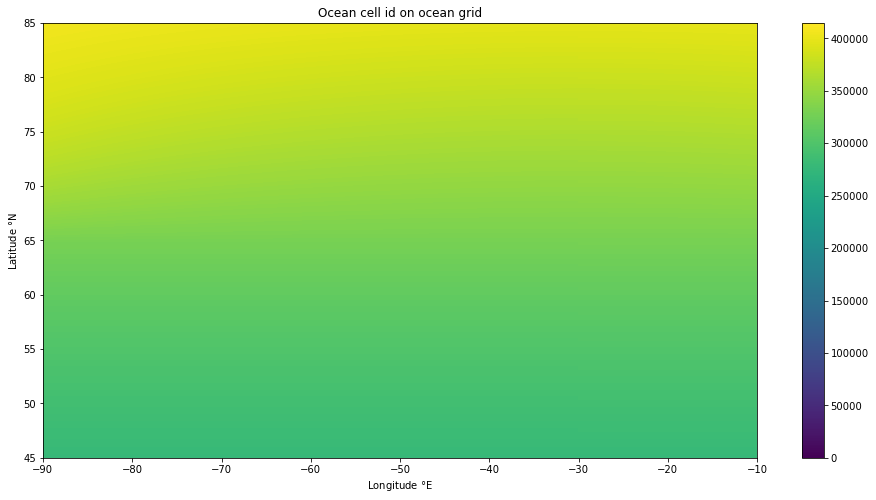

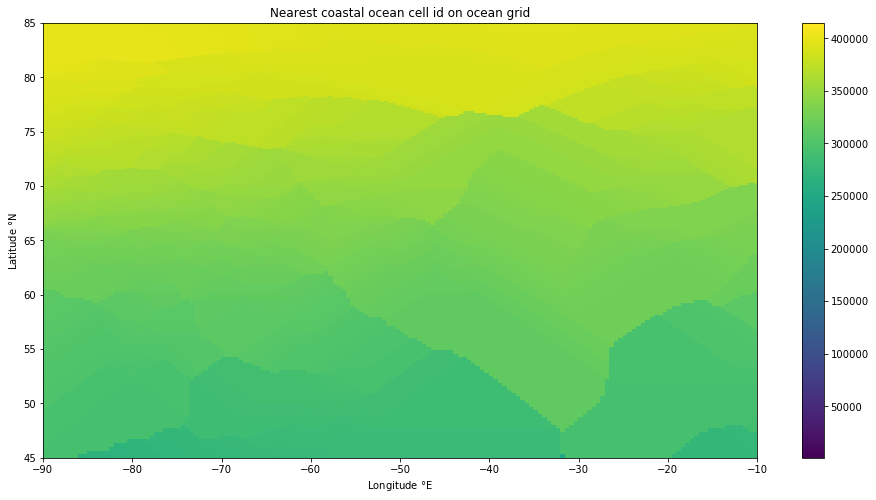

In [9]:
ocn_id = numpy.arange(cst_mask.size,dtype=numpy.int32).reshape(cst_mask.shape) # Ocean grid cell id
cst_nrst_ocn_id = ocn_id * cst_mask - (1 - cst_mask) # Will have nearest oid of coastal cells (-1 for unassigned)
ocidm = 1 * cst_mask # Mask for assigned field
while (cst_nrst_ocn_id<0).sum()>0:
    # Look east
    difm = numpy.roll( ocidm, -1, axis=1) - ocidm
    cst_nrst_ocn_id[ difm>0 ] = numpy.roll( cst_nrst_ocn_id, -1, axis=1)[ difm>0 ]
    ocidm[ cst_nrst_ocn_id>=0 ] = 1 # Flag all that have been assigned
    # Look west
    difm = numpy.roll( ocidm, 1, axis=1) - ocidm
    cst_nrst_ocn_id[ difm>0 ] = numpy.roll( cst_nrst_ocn_id, 1, axis=1)[ difm>0 ]
    ocidm[ cst_nrst_ocn_id>=0 ] = 1 # Flag all that have been assigned
    # Look south
    difm = numpy.roll( ocidm, 1, axis=0) - ocidm
    difm[0,:] = 0 # Non-periodic across south
    cst_nrst_ocn_id[ difm>0 ] = numpy.roll( cst_nrst_ocn_id, 1, axis=0)[ difm>0 ]
    ocidm[ cst_nrst_ocn_id>=0 ] = 1 # Flag all that have been assigned
    # Look north
    difm = numpy.roll( ocidm, -1, axis=0) - ocidm
    difm[-1,:] = 0 # *********************** THIS DOES NOT DO THE TRI-POLAR FOLD PROPERLY YET ***************
    cst_nrst_ocn_id[ difm>0 ] = numpy.roll( cst_nrst_ocn_id, -1, axis=0)[ difm>0 ]
    ocidm[ cst_nrst_ocn_id>=0 ] = 1 # Flag all that have been assigned
del difm, ocidm # Not to be used outside of this cell
plt.figure(figsize=(16,8));
plt.pcolormesh(ocn_qlon, ocn_qlat, ocn_id);plt.colorbar();
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('Ocean cell id on ocean grid');
regional_plot()
plt.figure(figsize=(16,8));
plt.pcolormesh(ocn_qlon, ocn_qlat, cst_nrst_ocn_id);plt.colorbar();
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('Nearest coastal ocean cell id on ocean grid');
regional_plot()

# Connect river cells to ocean cells

### Guess phase

Here we assume we will send data (mass flux) in each river-grid cell to one, and only one, ocean grid cell. To figure out the connections we take advantage of the regular-grid nature of the river grid. We start by setting the id-of-an-ocean-cell in each river-cell pointed to trivially by each ocean cell. Then we use ice9 to progagate ids acorss river-cells not touched trivially. This consistutes a "first guess" at the mapping.

### Correction phase

A correction is made by checking that each river cell center is within the ocean cell pointed to. If not, then we do a local gradient search on the ocean grid to correct the ocean cell id on the river grid.

# River data (assumes regular lat-lon grid)

Implied planetary radius = 6371.26 km


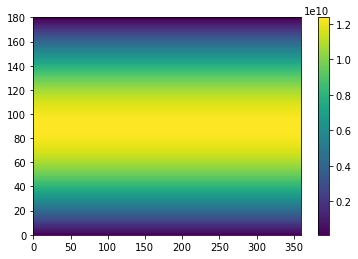

In [10]:
# River grid is regular
fetch_file_from_web('http://data1.gfdl.noaa.gov/~nnz/mom4/COREv2/data_IAF/CORRECTED/calendar_years/runoff.daitren.clim.10FEB2011.nc',
                   filename='river_runoff.nc')
runoff = netCDF4.Dataset('river_runoff.nc').variables['runoff']
rvr_nj, rvr_ni = runoff.shape[-2:]
rvr_res = 360.0/rvr_ni
rvr_lon = numpy.arange(0.5*rvr_res, 360., rvr_res)
rvr_lat = numpy.arange(-90.+0.5*rvr_res, 90., rvr_res)
rvr_qlon = numpy.arange(0, 360.0001, rvr_res)
rvr_qlat = numpy.arange(-90., 90.001, rvr_res)
rvr_nj, rvr_ni = rvr_lat.size, rvr_lon.size
rvr_id = numpy.arange(rvr_nj*rvr_ni,dtype=numpy.int32) # River grid cell id
Re, d2r = 6371.26e3, numpy.pi/180  # File had area => Re = 6371.26043437 km
rvr_area = numpy.outer( Re * ( numpy.sin( rvr_qlat[1:]*d2r ) - numpy.sin( rvr_qlat[:-1]*d2r ) ) ,Re*2*numpy.pi/rvr_ni*numpy.ones(rvr_ni))
del d2r, Re
plt.pcolormesh(rvr_area); plt.colorbar();
print('Implied planetary radius =',numpy.sqrt( rvr_area.sum()/(4*numpy.pi) )/1e3,'km')

# Create indirect index from ocean to river

- every ocean cell will have a center in an river cell

In [11]:
ocn_ri = ((1./rvr_res)*numpy.mod( ocn_lon, 360)).astype(int) # i-index in river-space of ocean cell
ocn_rj = ((1./rvr_res)*( ocn_lat+90.)).astype(int) # j-index in river-space of ocean cell
ocn_rid = ocn_ri + ocn_rj*rvr_ni

# Count how many ocean cell centers are in a river cell

- when the ocean grid is fine relative to the river grid we expect the count to be high;
- when the river grid is fine relative to the ocean grid we expect many river counts to be zero.

(array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
           9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
          18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
          27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
          36.,   37.,   40.,   41.,   44.,   45.,   46.,   47.,   49.,
          51.,   52.,   53.,   56.,   57.,   59.,   61.,   67.,   70.,
          71.,   76.,   78.,   81.,   92.,  109.,  135.,  169.,  175.,  218.]),
 array([ 4768,   360,   436,   448, 13564,   516, 23208,   628, 10838,
          776,  5058,   300,  2324,   180,   252,   148,   140,   120,
           68,    68,    76,    56,    56,    28,    36,    24,    20,
           20,    20,    20,    36,     4,    12,     8,    16,    16,
            8,    12,    12,     8,     8,     8,     4,     8,     4,
            8,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     

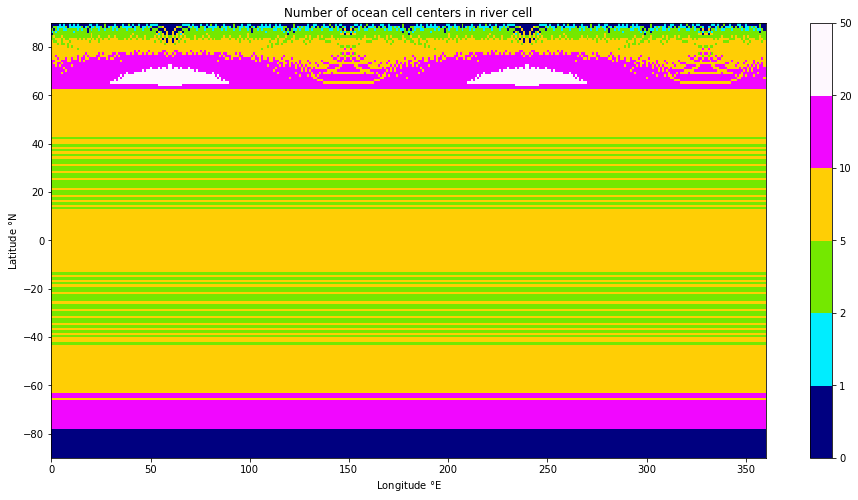

In [12]:
rvr_ocells_in_rcells = numpy.zeros((rvr_nj*rvr_ni)) # Counter on river grid
rids, cnt = numpy.unique( ocn_rid, return_counts=True )
rvr_ocells_in_rcells[rids] = cnt
del rids, cnt
plt.figure(figsize=(16,8))
plt.pcolormesh(rvr_qlon, rvr_qlat, rvr_ocells_in_rcells.reshape(rvr_nj,rvr_ni),
               norm=colors.BoundaryNorm(boundaries=[0,1,2,5,10,20,50], ncolors=256), cmap='gist_ncar'); plt.colorbar();
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('Number of ocean cell centers in river cell');
#regional_plot()
numpy.unique( rvr_ocells_in_rcells, return_counts=True )

# Build a k-d tree for efficient searching of the curvilinear ocean grid

In [13]:
class kdtree:
    @jit
    def __init__(self, lat, lon, level=0, i0=None, i1=None, j0=None, j1=None):
        """Contructs a k-d tree for a mesh with nodes at (lon,lat)."""
        self.level = level
        if level==0:
            j0, j1 = 0, lon.shape[0]
            i0, i1 = 0, lon.shape[1]
        self.j0, self.j1 = j0, j1
        self.i0, self.i1 = i0, i1
        nj, ni = j1-j0-1, i1-i0-1
        if (nj,ni)==(1,1):
            self.end = True
            self.xmin, self.xmax = lon[j0:j1,i0:i1].min(), lon[j0:j1,i0:i1].max()
            self.ymin, self.ymax = lat[j0:j1,i0:i1].min(), lat[j0:j1,i0:i1].max()
            self.lat, self.lon = lat[j0:j1,i0:i1], lon[j0:j1,i0:i1]
        else:
            self.end = False
            pj, pi = kdtree.first_divisor(nj), kdtree.first_divisor(ni)
            rj, ri = nj//pj, ni//pi # Size of the sub-array for this level
            self.leaves = list()
            xmin, xmax, ymin, ymax = lon[j0,i0], lon[j0,i0], lat[j0,i0], lat[j0,i0]
            for jj in range(pj):
                di = list()
                jj0, jj1 = j0+jj*rj, j0+(jj+1)*rj+1
                for ii in range(pi):
                    ii0, ii1 = i0+ii*ri, i0+(ii+1)*ri+1
                    q = kdtree( lat, lon, level=level+1, i0=ii0, i1=ii1, j0=jj0, j1=jj1)
                    di.append( q )
                    xmin, xmax = min(xmin, q.xmin), max(xmax, q.xmax)
                    ymin, ymax = min(ymin, q.ymin), max(ymax, q.ymax)
                self.leaves.append(di)
            self.xmin, self.xmax = xmin, xmax
            self.ymin, self.ymax = ymin, ymax
    @jit
    def first_divisor(n):
        """Returns the smallest, non-unity divisor of n."""
        for d in range(2,n//2+1):
            if n%d==0: return d
        return n
    @jit
    def sign_of_loc_p_on_ab(a_lon, a_lat, b_lon, b_lat, p_lon, p_lat):
        """Returns positive real if P to the right of AB, negative if to the left, and zero if P is on AB
        or AB has zero length."""
        return ( a_lat - p_lat) * ( b_lon - a_lon ) - ( a_lon - p_lon ) * ( b_lat - a_lat )
    def inside(left, right, val):
        if val>=left and val<right: return True
        return False
    def id2s(self):
        return ' '*self.level + '%i:%i-%i,%i-%i'%(self.level,self.j0,self.j1,self.i0,self.i1)
    #@jit
    def find_cell(self, lat, lon, debug=False):
        debug_point = kdtree.inside(self.j0,self.j1,114) and kdtree.inside(self.i0,self.i1,359) and debug
        if debug_point:
            print(self.id2s(),'end=',self.end)
            print(self.id2s(),'min/lat/max=',self.ymin,lat,self.ymax)
            print(self.id2s(),'min/lon/max=',self.xmin,lon,self.xmax)
        # First bounding box to reject (to minimize cost)
        if lat<self.ymin:
            if debug_point: print(self.id2s(),'Rejecting ymin')
            return None, None
        if lat>=self.ymax:
            if debug_point: print(self.id2s(),'Rejecting ymax')
            return None, None
        if self.level>1: # This avoids false rejects when the level is for the whole grid
            if (((lon-self.xmin)+180) % 360)<180:
                if debug_point: print(self.id2s(),'Rejecting xmin')
                return None, None
            #if lon<self.xmin: return False, None, None
            if (((lon-self.xmax)+180) % 360)>=180:
                if debug_point: print(self.id2s(),'Rejecting xmax')
                return None, None
            #if lon>=self.xmax: return False, None, None
        if self.end:
            if debug_point:
                print(self.id2s(),'0,0=',self.lon[0,0], self.lat[0,0])
                print(self.id2s(),'0,1=',self.lon[0,1], self.lat[0,1])
                print(self.id2s(),'1,1=',self.lon[1,1], self.lat[1,1])
                print(self.id2s(),'1,0=',self.lon[1,0], self.lat[1,0])
            if kdtree.sign_of_loc_p_on_ab( self.lon[0,0], self.lat[0,0], self.lon[0,1], self.lat[0,1],
                                        lon, lat ) > 0:
                if debug_point: print(self.id2s(),'Rejecting 00-01')
                return None, None
            if kdtree.sign_of_loc_p_on_ab( self.lon[1,0], self.lat[1,0], self.lon[0,0], self.lat[0,0],
                                        lon, lat ) > 0:
                if debug_point: print(self.id2s(),'Rejecting 10-00')
                return None, None
            if kdtree.sign_of_loc_p_on_ab( self.lon[0,1], self.lat[0,1], self.lon[1,1], self.lat[1,1],
                                        lon, lat ) >= 0:
                if debug_point:
                    print( kdtree.sign_of_loc_p_on_ab( self.lon[0,1], self.lat[0,1], self.lon[1,1], self.lat[1,1],
                                        lon, lat ) )
                    print(self.id2s(),'Rejecting 01-11')
                return None, None
            if kdtree.sign_of_loc_p_on_ab( self.lon[1,1], self.lat[1,1], self.lon[1,0], self.lat[1,0],
                                        lon, lat ) >= 0:
                if debug_point: print(self.id2s(),'Rejecting 11-10')
                return None, None
            if debug_point: print('FOUND!', self.j0, self.i0)
            return self.j0, self.i0
        else:
            res, j, i = False, None, None
            for jl in self.leaves:
                for il in jl:
                    this_j, this_i = il.find_cell(lat, lon, debug=debug)
                    if debug and self.end: print(self.id2s(),
                        'min/lat/max=',self.ymin,lat,self.ymax,
                        'min/lon/max=',self.xmin,lon,self.xmax)
                    if this_j is not None:
                        if debug: print(self.id2s(),this_j, this_i)
                        if res: raise Exception('Two positive results!')
                        res = True
                        j, i = this_j, this_i
            if self.level>0:
                if debug_point: print(self.id2s(),'>0 returning', j, i)
                return j, i
        return j,i

In [14]:
%time ocn_kdtree = kdtree(ocn_qlat, ocn_qlon)

CPU times: user 48.7 s, sys: 638 ms, total: 49.4 s
Wall time: 49.1 s


# Record id of ocean cells on river grid

## Index river cell from ocean cell coordinates

- There is no one-to-one relationship guaranteed here
  - There might be many ocean cell centers within a river cell
  - If the ocean is relatively coarse, only a subset of river cells will be associated

4768/64800 river cells without associated ocean id


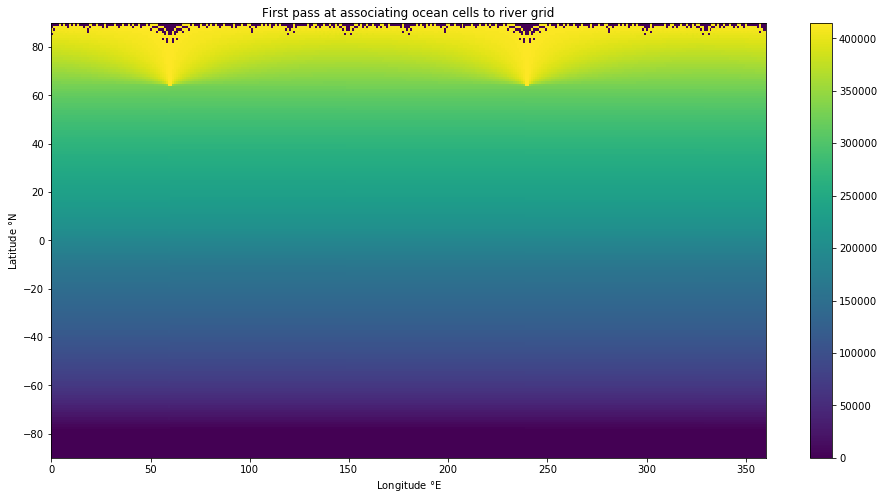

In [15]:
rvr_oid = numpy.zeros((rvr_nj,rvr_ni),dtype=numpy.int32) - 1 # Will hold id of ocean cell overlying river grid
rvr_oid[ ocn_rj.flatten(), ocn_ri.flatten() ] = ocn_id.flatten() # Associate river cell to an ocean cell
#rvr_oid[ rvr_ocells_in_rcells.flatten()>1 ] = -1
print('%i/%i river cells without associated ocean id'%((rvr_oid<0).sum(),rvr_oid.size))
plt.figure(figsize=(16,8))
plt.pcolormesh(rvr_qlon, rvr_qlat, rvr_oid); plt.colorbar();
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('First pass at associating ocean cells to river grid');
#regional_plot()

## Using river cell centers, find ocean cell

4768/64800 river cells without associated ocean id before
CPU times: user 304 ms, sys: 5 ms, total: 309 ms
Wall time: 307 ms
4320/64800 river cells without associated ocean id after
0/64800 river cells without associated ocean id in NH
4320/64800 river cells without associated ocean id in SH


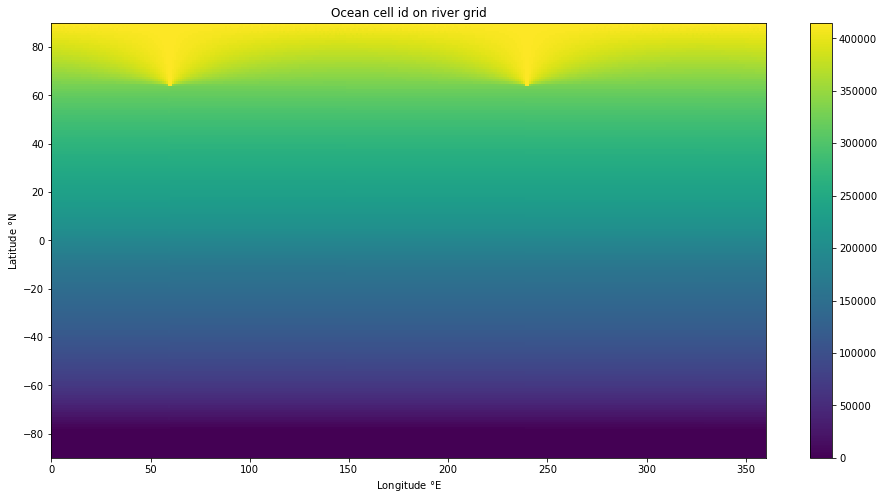

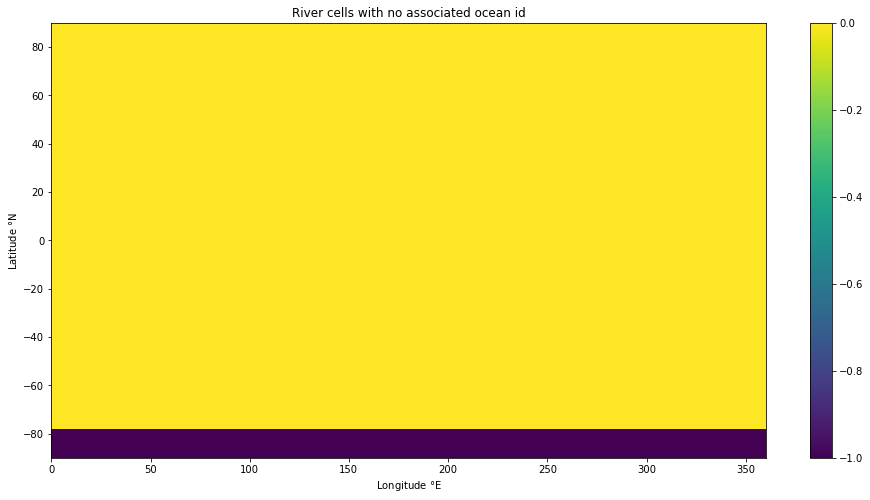

In [16]:
def search_kdtree_for_ocn_ij(ocn_kdtree, ocn_ni, rvr_lat, rvr_lon, rvr_oid):
    rvr_nj, rvr_ni = rvr_oid.shape
    for rid in rvr_id[ (rvr_oid<0).flatten() ]:
        j, i = ocn_kdtree.find_cell( rvr_lat[int(rid/rvr_ni)], rvr_lon[rid%rvr_ni] )
        if j is None: j, i = ocn_kdtree.find_cell( rvr_lat[int(rid/rvr_ni)], rvr_lon[rid%rvr_ni]-360. )
        if j is None: j, i = ocn_kdtree.find_cell( rvr_lat[int(rid/rvr_ni)], rvr_lon[rid%rvr_ni]+360. )
        if j is not None: rvr_oid[int(rid/rvr_ni),rid%rvr_ni] = j * ocn_ni + i
    return rvr_oid
print('%i/%i river cells without associated ocean id'%((rvr_oid<0).sum(),rvr_oid.size), 'before')
%time search_kdtree_for_ocn_ij(ocn_kdtree, ocn_ni, rvr_lat, rvr_lon, rvr_oid)
print('%i/%i river cells without associated ocean id'%((rvr_oid<0).sum(),rvr_oid.size), 'after')
print('%i/%i river cells without associated ocean id'%((rvr_oid[rvr_lat>=0,:]<0).sum(),rvr_oid.size), 'in NH')
print('%i/%i river cells without associated ocean id'%((rvr_oid[rvr_lat<0,:]<0).sum(),rvr_oid.size), 'in SH')
# rvr_oid[ rvr_ocells_in_rcells.reshape(rvr_nj,rvr_ni)>0 ] = -1
plt.figure(figsize=(16,8))
plt.pcolormesh(rvr_qlon, rvr_qlat, rvr_oid); plt.colorbar();
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('Ocean cell id on river grid');
#regional_plot()
plt.figure(figsize=(16,8))
plt.pcolormesh(rvr_qlon, rvr_qlat, numpy.minimum(0,rvr_oid)); plt.colorbar();
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('River cells with no associated ocean id');
#regional_plot()

In [17]:
def brute_force_search_for_ocn_ij( ocn_lat, ocn_lon, lat, lon):
    cost = numpy.abs( ocn_lat - lat) + numpy.abs( numpy.mod(ocn_lon - lon + 180, 360) - 180 )
    return numpy.argmin( cost )
print('%i/%i river cells without associated ocean id'%((rvr_oid<0).sum(),rvr_oid.size), 'before')
for rid in rvr_id[ (rvr_oid.flatten()<0) ]:
    rj, ri = int(rid/rvr_ni), rid%rvr_ni
    oid = brute_force_search_for_ocn_ij( ocn_lat, ocn_lon, rvr_lat[rj], rvr_lon[ri])
    rvr_oid[rj, ri] = oid
print('%i/%i river cells without associated ocean id'%((rvr_oid<0).sum(),rvr_oid.size), 'after')

4320/64800 river cells without associated ocean id before
0/64800 river cells without associated ocean id after


# Create sparse matrix

- For ocean cells with many intersecting river cells (i.e. river cells with count <=1):
  - enter river cell areas in river column for corresponding ocean cell row.
- For river cells with more than N>1 ocean cells:
  - enter 1/Nth of river cell area in each row of one column.

In [18]:
# In the OxR matrix, enter the river-cell area along a row, for each river cell within an ocean cell
Arow = scipy.sparse.lil_matrix( (ocn_nj*ocn_ni, rvr_nj*rvr_ni), dtype=numpy.double )
rids = rvr_id[rvr_ocells_in_rcells<=1]
# rvr_oid.flatten()[rids] is the ocean cell id for each river cell
# cst_nrst_ocn_id.flatten()[ oid ] is the coastal cell id for oid
#oids = cst_nrst_ocn_id.flatten()[ rvr_oid.flatten()[rids] ]
oids = rvr_oid.flatten()[rids] # debug without coastal mapping
Arow[oids,rids] = rvr_area.flatten()[rids]
Arow

<414720x64800 sparse matrix of type '<class 'numpy.float64'>'
	with 5128 stored elements in LInked List format>

In [19]:
# plt.figure(figsize=(16,8))
# plt.pcolormesh(rvr_qlon, rvr_qlat, numpy.ma.log10(Ar.toarray().sum(axis=0).reshape(rvr_nj, rvr_ni))); plt.colorbar();
# plt.title('A col-sum (river-grid)');
# #regional_plot()
# plt.figure(figsize=(16,8))
# plt.plot( Ar.toarray().sum(axis=0) , label='A col-sum');
# plt.plot( rvr_area.flatten(), label='river area');
# plt.legend();

In [20]:
# In the OxR matrix, enter the fraction of a river-cell area in columns for each ocean cell with a river cell
Acol = scipy.sparse.lil_matrix( (ocn_nj*ocn_ni, rvr_nj*rvr_ni), dtype=numpy.double )
rids = ocn_rid.flatten()
oids = ocn_id.flatten() # debug without coastal mapping
cnt = rvr_ocells_in_rcells.flatten()[rids]
rids = rids[cnt>1]
oids = oids[cnt>1]
#oids = cst_nrst_ocn_id.flatten()[oids]
Acol[oids, rids] = rvr_area.flatten()[rids] / rvr_ocells_in_rcells[rids]
Acol

<414720x64800 sparse matrix of type '<class 'numpy.float64'>'
	with 414360 stored elements in LInked List format>

In [21]:
# plt.figure(figsize=(16,8))
# plt.pcolormesh(rvr_qlon, rvr_qlat, numpy.ma.log10(Ac.toarray().sum(axis=0).reshape(rvr_nj, rvr_ni))); plt.colorbar();
# plt.title('A col-sum (river-grid)');
# plt.figure(figsize=(16,8))
# plt.plot( Ac.toarray().sum(axis=0) , label='A col-sum');
# plt.plot( rvr_area.flatten(), label='river area');
# plt.legend();

In [22]:
# Is is an O-R sparse matrix with units of m2 so it can multiply runoff in units of kg m-2 s-1
A = (Arow + Acol).tocsr()
A

<414720x64800 sparse matrix of type '<class 'numpy.float64'>'
	with 419488 stored elements in Compressed Sparse Row format>

In [23]:
# plt.figure(figsize=(16,8))
# plt.pcolormesh(rvr_qlon, rvr_qlat, numpy.ma.log10(A.toarray().sum(axis=0).reshape(rvr_nj, rvr_ni))); plt.colorbar();
# plt.title('A col-sum (river-grid)');
# plt.figure(figsize=(16,8))
# plt.plot( A.toarray().sum(axis=0) , label='A col-sum');
# plt.plot( rvr_area.flatten(), label='river area');
# plt.legend();

In [24]:
# Sparse matrix to represent redirection to nearest coastal cell
Acst = scipy.sparse.lil_matrix( (ocn_nj*ocn_ni, ocn_nj*ocn_ni), dtype=numpy.double )
Acst[cst_nrst_ocn_id, ocn_id] = 1
A = Acst * A
A

<414720x64800 sparse matrix of type '<class 'numpy.float64'>'
	with 117294 stored elements in Compressed Sparse Row format>

In [25]:
# plt.figure(figsize=(16,8))
# plt.pcolormesh(rvr_qlon, rvr_qlat, numpy.ma.log10(A.toarray().sum(axis=0).reshape(rvr_nj, rvr_ni))); plt.colorbar();
# plt.title('A col-sum (river-grid)');
# plt.figure(figsize=(16,8))
# plt.plot( A.toarray().sum(axis=0) , label='A col-sum');
# plt.plot( rvr_area.flatten(), label='river area');
# plt.legend();

In [26]:
# plt.figure(figsize=(16,8))
# plt.pcolormesh(rvr_qlon, rvr_qlat, numpy.ma.log10(ra.reshape(rvr_nj, rvr_ni))); plt.colorbar(); plt.title('A row-sum (river-grid)')
# plt.figure(figsize=(16,8))
# plt.pcolormesh(ocn_qlon, ocn_qlat, numpy.ma.log10(oa.reshape(ocn_nj, ocn_ni))); plt.colorbar(); plt.title('A col-sum (ocean grid)')
# #plt.xlim(0,20);
# plt.figure(figsize=(16,8))
# plt.plot( ra , label='A row-sum');
# plt.plot( rvr_area.flatten(), label='river area');
# plt.legend();
# #plt.xlim(56215,56227)
# print( ra[56219], rvr_area.flatten()[56219] )
# plt.figure(figsize=(16,8))
# plt.pcolormesh(ocn_qlon, ocn_qlat, A.toarray()[:,56219].reshape(ocn_nj, ocn_ni) ); plt.colorbar();
# #plt.xlim(50,61)
# #plt.ylim(60,70)

Net runoff on river grid =  917645509.127 kg/s
Net runoff on ocean grid =  917645509.127 kg/s


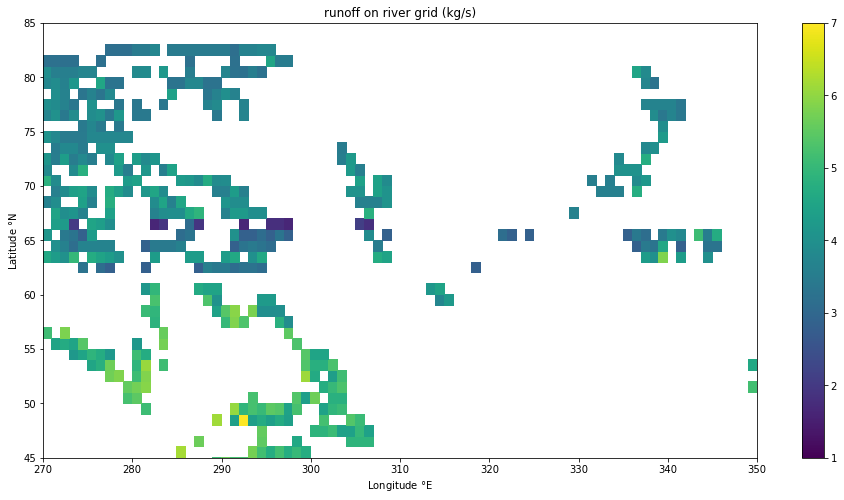

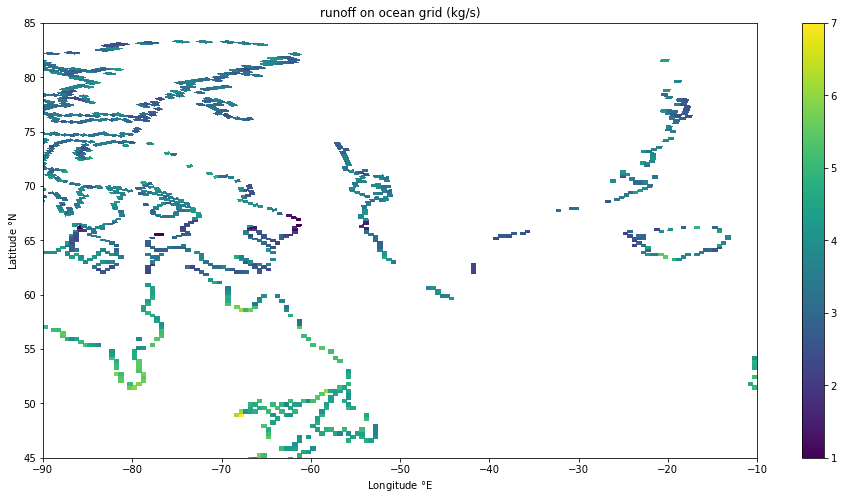

In [27]:
# Uses netcdf handle "runoff" opened earlier
time = 0
plt.figure(figsize=(16,8))
# r_flux is in kg m-2 s-1
r_flux = numpy.roll( runoff[time], int(rvr_ni/2), axis=1) # Rolls data so longitudes are 0..360
plt.pcolormesh(rvr_qlon, rvr_qlat, numpy.ma.log10( rvr_area * r_flux ) ); plt.colorbar();
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('runoff on river grid (kg/s)')
regional_plot()
plt.clim(1,7)
plt.figure(figsize=(16,8))
# o_kg is in kg s-1
o_kg = ( A * r_flux.flatten() ).reshape(ocn_mask.shape)
plt.pcolormesh(ocn_qlon, ocn_qlat, numpy.ma.log10( o_kg ) ); plt.colorbar();
plt.xlabel('Longitude $\degree$E'); plt.ylabel('Latitude $\degree$N');
plt.title('runoff on ocean grid (kg/s)')
regional_plot()
plt.clim(1,7)
print('Net runoff on river grid = ', (rvr_area * r_flux).sum(), 'kg/s')
print('Net runoff on ocean grid = ', o_kg.sum(), 'kg/s')